### RFM 기반 고객 (플레이어) 세그먼테이션 (이탈 가능성을 분석하기 이전 단계 프로세스) 프로젝트 by 고강우 (Fabio Ko)

### 내용 : 플레이어 기준 로그인기간, 아이템 구매횟수, 아이템 구매금액에 기반한 RFM 스코어 산출

##### - Recency : 플레이어별 로그인기간, 분석일 기준 최근 로그인(days) // attrition(이탈) 가능성을 사전 분석하기 위한 핵심 기준

##### - Frequency : 플레이어별 구매건수

##### - Monetary : 플레이어별 구매금액

### 기대 효과 : 상기 3개 게임콘텐츠 key performance index (kpi)에 기반하여, 하나의 통합된 RFM 스코어를 산출함. 본 RFM 스코어는 추후 sorting 등 추가 가공을 통해 플레이어 이탈 가능성이나 우수 고객 정도성을 예측하는 기반 데이터로 활용 가능함. 더불어, 플레이어 (고객) Segmentation 시, 주요 classification 지표로 활용 가능함

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score


In [0]:
# RFM 기반 데이터 분석

# 게임 플레이어(고객) 세그먼테이션(game player segmentation)
# 다양한 기준으로 게임 플레이어를 분류하는 기법
# 게임콘텐츠 분석에 있어, CRM이나 마케팅의 중요한 기반 요소

# 게임플레이어를 분류하는 방법은 다양함
# => 거주지역/결혼여부/성별/소득/직업
# => 선호아이템군/월별결제(현질)액/최근구매아이템/아이템구매주기
# ==> 게임회사 입장에서는 얼마나 많은 매출을 발생하느냐가 
#     플레이어 기준을 정하는 중요한 요소
# ==> 주요 목표는 타겟 마케팅!!
# ==> 하지만, 위의 경우 게임플레이어의 "인적사항"에 관련한 것이고,
# 본 게임콘텐츠 analysis는 "게임 캐릭터"를 기준으로 함 (구분자 : Player_ID)

# 따라서, 게임플레이어의 어떤 요소를 기반으로 
# 군집화 할 것인가를 결정하는 것이 중요
# => RFM 기법 이용
# => recency, frequency, monetary


# recency 계정 로그인 최근성
# 게임플레이어의 마지막 계정 접속 시점이 언제인지를 의미

# frequency 아이템 구매 빈도
# 게임플레이어가 정해진 기간동안 얼마나 아이템을 자주 구매했나

# monetary 아이템 구매 금액
# 일정기간 동안에 게임플레이어의 총 아이템 구매금액을 나타냄

# RFM 지수 = a * R + b * F + c * M
# a, b, c는 가중치


# recency 가 중요한 산업 : 유통업(백화점, 보험), 게임산업 (이탈 방지 목적)
# frequency 가 중요한 산업 : 통신업, 유통업, 서비스업, 게임산업 (이탈 방지 목적)
# monetary 가 중요한 산업 : 금융업(카드사), 게임산업 (이탈 방지 목적)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284700 entries, 0 to 284699
Data columns (total 8 columns):
Player_ID1          284700 non-null object
Item_Code           284700 non-null object
Conversation        283620 non-null object
Item_quant          284699 non-null float64
Last_Log_in_Date    284699 non-null object
Item_Bought_USD     284699 non-null float64
Player_ID           203678 non-null float64
Country             284699 non-null object
dtypes: float64(3), object(5)
memory usage: 17.4+ MB


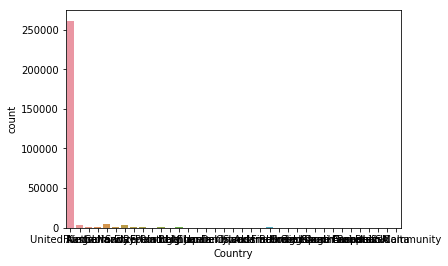

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Player_ID1  Item_Code
536365      21730        1
            22752        1
            71053        1
            84029E       1
            84029G       1
            84406B       1
            85123A       1
536366      22632        1
            22633        1
536367      21754        1
Name: Player_ID1, dtype: int64

In [28]:
# 데이터 적재
gameplayer = pd.read_csv('Contents_GamePlayer.csv')
# => MMORPG 게임에서 발생한 거래 데이터
#    2010.01 ~ 2011.09 까지의 데이터 저장
# 플레이어 소속 (접속 IP 기준) 국가는 다양함

gameplayer.info()
# 전체 데이터 : 541909 
# 플레이어 ID : 406829 

gameplayer.head()
gameplayer.describe()   # 아이템 수량과 가격이 마이너스로 표시



# 게임콘텐츠 분석을 적용할 대상 국가 (플레이어 접속국가) 선정
gameplayer.Country.value_counts()

sns.countplot(gameplayer.Country)
plt.show()
# => 플레이어 분포는 영국, 독일, 프랑스, 아일랜드 순
# 영국이 압도적으로 많음. 따라서, 본 분석에서는 
# 분석 간략화를 위해 영국 플레이어들을 대상으로 RFM 분석
# (실무적으로는 전체 플레이어 대상 분석이 필요할 것으로 사료됨)


# 플레이어 ID 데이터 수가 406829 이므로 적절한 기준으로 결측치 처리함
# 아이템 구매수량, 구매가격이 0 이상인 데이터를 대상으로 결측치 처리함
gameplayer.shape   # (541909, 8)

gameplayer.isnull().sum()

gameplayerdf = gameplayer[gameplayer.Item_quant > 0]
gameplayerdf = gameplayerdf[gameplayer.Item_Bought_USD > 0]
gameplayerdf = gameplayerdf[gameplayer.Player_ID.notnull()]

gameplayerdf.isnull().sum()

gameplayerdf.shape   # (397884, 8)



# 플레이어를 영국으로 한정함
gameplayerdf.Country.value_counts()[:5]

gameplayeruk = gameplayerdf[gameplayerdf.Country == 'United Kingdom']

gameplayeruk.Country.value_counts()[:5]   # 354321



# 탐색적 분석(EDA)
gameplayeruk.describe()



# BFM 분석
# 분석에 필요한 컬럼들로만 필터링
gameplayeruk.columns

uk_data = gameplayeruk[[
    'Player_ID',
    'Last_Log_in_Date',
    'Player_ID1',
    'Item_Code',
    'Item_quant',
    'Item_Bought_USD' ]]

# 플레이어번호를 정수로 변환
uk_data['Player_ID'] = uk_data.loc[:,'Player_ID'].astype(int)

# 아이템 수량과 단가를 이용해서 구매금액 산출
uk_data['Item_Bought_USD'] = uk_data['Item_quant'] * uk_data['Item_Bought_USD']

# 플레이어별 구매건수 확인
uk_data['Player_ID'].value_counts().head(10)

# 플레이어별 구매금액 확인
uk_data.groupby('Player_ID')['Item_Bought_USD'].sum().sort_values(
    ascending=False)[:10]

# 아이템 구매건수가 많다고 해서 아이템 총구매금액이 높은 것은 아님
# => 구매건당 금액이 높기 때문임
# => 게임콘텐츠 분석에 있어서 단순한 item 구매 frequency가 아닌,
# 총구매금액 (건 당 금액 분석 포함)에 집중해야 하는 이유는,
# 결국 "부유한 플레이어", 즉 priority segment에 속하는 고객을
# retain하는 것이 중요하기 때문


# 상품별 구매빈도 파악
uk_data['Item_Code'].value_counts()
uk_data['Item_Code'].value_counts().head(10)

uk_data.groupby(['Player_ID1', 'Item_Code'])['Player_ID1'].count()[:10]

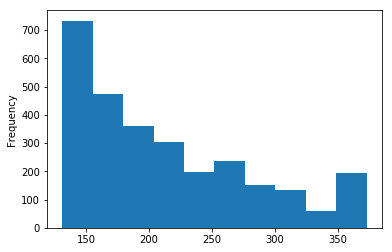

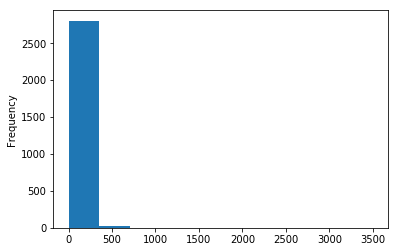

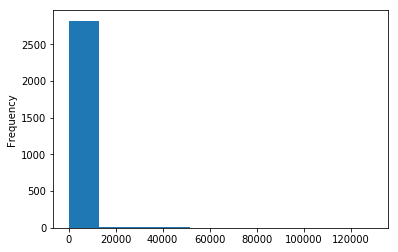

,Player_ID,Recency,Frequency,Monetary
count,2846.000000,2846.000000,2846.000000,2846.000000
mean,15550.081518,212.155657,62.064301,1310.897492
std,1583.202759,68.282933,121.429918,4345.940590
min,12346.000000,131.000000,1.000000,2.900000
25%,14194.250000,155.000000,14.000000,243.840000
50%,15546.000000,192.000000,30.000000,497.320000
75%,16912.750000,256.750000,70.000000,1142.282500
max,18287.000000,373.000000,3503.000000,129551.310000


In [29]:
# RFM 기반 플레이어 세그먼테이션 수행
# => 플레이어 기준 로그인기간, 아이템 구매횟수, 아이템 구매금액 산출

# Recency : 플레이어별 로그인기간, 
#           분석일 기준 최근 로그인(days) // attrition(이탈) 가능성을
#           사전 분석하기 위한 핵심 기준
# Frequency : 플레이어별 구매건수
# Monetary : 플레이어별 구매금액

uk_data['Recency'] : uk_data.groupby('Player_ID')['Last_Log_in_Date'].max()
uk_data['Frequency'] : uk_data.groupby('Player_ID')['Player_ID1'].count()
uk_data['Monetary'] : uk_data.groupby('Player_ID')['Item_Bought_USD'].sum()



# 독립적인 데이터프레임을 생성한 후 플레이어에 대한 RFM 분석 저장
uk_RFM_data  = uk_data.groupby('Player_ID').agg(
    { 'Last_Log_in_Date' : 'max',
      'Player_ID1' : 'count', 
      'Item_Bought_USD' : 'sum' })



# 컬럼명을 R / F / M 으로 변경
uk_RFM_data.rename(columns={
    'Last_Log_in_Date' : 'Recency', 
    'Player_ID1' : 'Frequency', 
    'Item_Bought_USD' : 'Monetary'}, inplace=True)



# 데이터프레임의 인덱스가 플레이어 ID 이므로
# 인덱스를 재조정함
uk_RFM_data = uk_RFM_data.reset_index()



# Recency 재가공
# Recency는 분석일 기준 플레이어당 최근 구매
# => Recency = 분석일 - 최근 구매일
uk_data['Last_Log_in_Date'].min()   # 2010-12-01
uk_data['Last_Log_in_Date'].max()   # 2011-12-09

# 따라서, 분석일은 2011-12-10 로 설정
# 날짜 연산을 위해 pandas에서 지원하는 날짜형으로 변환
# '2011-12-10' - '2011-12-01' => 계산불가!! 
pd.to_datetime('2011-12-10') - pd.to_datetime('2011-12-01')
# => Timedelta('9 days 00:00:00')

uk_RFM_data['Recency'] = \
pd.to_datetime('2011-12-10') - pd.to_datetime(uk_RFM_data['Recency'])

# 계산된 결과에서 일수만 추출
uk_RFM_data['Recency'] = uk_RFM_data['Recency'].dt.days



# RFM 분석 결과를 시각화
uk_RFM_data['Recency'].plot(kind='hist')
plt.show()

uk_RFM_data['Frequency'].plot(kind='hist')
plt.show()

uk_RFM_data['Monetary'].plot(kind='hist')
plt.show()
# 데이터 분포는 왜곡되어 있음 - 한 쪽으로 쏠림



# RFM 분석 결과에 기술통계
uk_RFM_data.describe()

#          	 Recency	      Frequency	        Monetary
# count	     3920.000000	  3920.000000	    3920.000000
# mean	   	 91.742092 	      90.388010	        1864.385601
# std	   	 99.533485	      217.808385	    7482.817477
# min	   	 0.000000	      1.000000	        3.750000
# 25%	   	 17.000000	      17.000000	        300.280000
# 50%	   	 50.000000	      41.000000	        652.280000
# 75%	     142.000000	      99.250000	        1576.585000
# max	   	 373.000000	      7847.000000	    259657.300000

# 평균이 중위수보다 큼 => 이상치에 의해 평균이 끌어올려졌음을 의미
# 정규분포 아님 => 왜곡이 심한편임을 알 수 있음
# => 왜곡 정도가 높은 데이터에 대해 
#    kmeans 군집화를 적용시키면 변별력이 떨어지는 결과 도출
# ==> 정규화를 통해 평균과 표준편차 재조정 필요

실루엣 점수 0.5003319417025076
실루엣 점수 0.5003319417025076


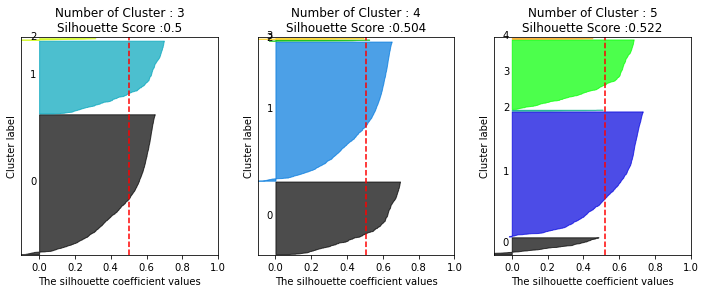

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


실루엣 점수 0.3260434144150678


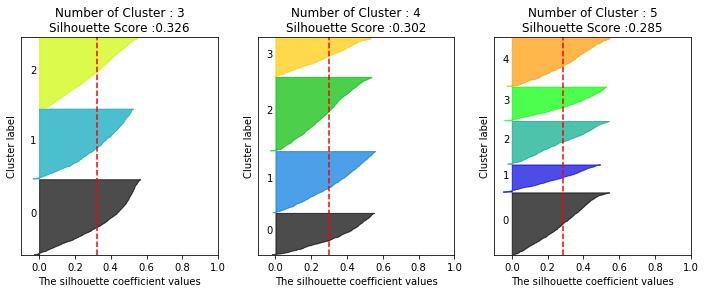

In [30]:
# 정규화 수행후 kmeans 군집화 적용
from sklearn.preprocessing import StandardScaler

X = uk_RFM_data.iloc[:, 1:4]
X_scaled = StandardScaler().fit_transform(X)

kms = KMeans(n_clusters=3, random_state=0)
labeled = kms.fit_predict(X_scaled)

print('실루엣 점수', silhouette_score(X_scaled, labeled))
# => 실루엣 점수 0.5923691942714455


kms = KMeans(n_clusters=5, random_state=0)
labeled2 = kms.fit_predict(X_scaled)

print('실루엣 점수', silhouette_score(X_scaled, labeled))
# => 실루엣 점수 0.6036943581226247



# 군집별 분포수 확인
pd.Series(labeled2).value_counts()
# 각 군집별 분포수는 균일하지 않음



# 실루엣 그래프 시각화
import kmeans_eval

kmeans_eval.visualize_silhouette([3, 4, 5], X_scaled)
# 그래프를 확인해보면 군집이 제대로 이루어지지 않음
# => 분포가 왜곡되어 있어 데이터들이 겹쳐져있기 때문 



# 왜곡된 데이터 분포를 재조정하기 위해 
# 데이터 값에 로그를 적용하는 로그변환 사용
uk_RFM_data['Recency_log'] = np.log1p(uk_RFM_data['Recency'])
uk_RFM_data['Frequency_log'] = np.log1p(uk_RFM_data['Frequency'])
uk_RFM_data['Monetary_log'] = np.log1p(uk_RFM_data['Monetary'])
# 각 값에 log 적용시 결과값이 무한대로 발산되는 경우(-inf)를 
# 방지하기 위해 결과값에 +1 해주는 로그함수 사용

a = np.array([0, 12345])
np.log(a)   # -inf, 9.4210064
np.log1p(a)



# 로그변환된 데이터를 이용해서 kmeans 군집화 적용하기
X2 = uk_RFM_data.iloc[:, 4:7]

X2_scaled = StandardScaler().fit_transform(X2)
kms = KMeans(n_clusters=3, random_state=0)

labeled2 = kms.fit_predict(X2_scaled)

print('실루엣 점수', silhouette_score(X2_scaled, labeled2))
# 실루엣 점수 0.3062580508120836


kmeans_eval.visualize_silhouette([3, 4, 5], X2_scaled)
# 실루엣 점수는 낮지만, 로그변환 덕택으로 인해 군집화는 잘 되었음

In [31]:
print(uk_RFM_data['Recency'].head())
print()
print(uk_RFM_data['Frequency'].head())
print()
print(uk_RFM_data['Monetary'].head())

0    325
1    164
2    133
3    213
4    326
Name: Recency, dtype: int64

0       1
1      63
2    1840
3      43
4      11
Name: Frequency, dtype: int64

0    77183.60
1     2467.70
2    12669.06
3      859.10
4      170.46
Name: Monetary, dtype: float64


In [32]:
# 프로그래밍 관점에서 RFM 분석
# RFM 데이터를 구간별로 나눠서 가중치 부여
# qcut(데이터, 구간수, 가중치리스트)


# 게임 아이템 구매 관련 분석

uk_RFM_data['R_quart'] = pd.qcut(
    uk_RFM_data['Recency'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['R_quart'].value_counts()
# 구매일자 기준, 가장 최근에 구매한 플레이어에게 높은 가중치 부여

uk_RFM_data['F_quart'] = pd.qcut(
    uk_RFM_data['Frequency'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['Frequency'].value_counts()
# 구매빈도가 높은 플레이어에게 높은 가중치 부여

uk_RFM_data['M_quart'] = pd.qcut(
    uk_RFM_data['Monetary'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['Monetary'].value_counts()
# 구매금액이 높은 플레이어에게 높은 가중치 부여



# RFM 점수 산출
uk_RFM_data.iloc[:, 7:10].head(5)

uk_RFM_data['RFM score'] = uk_RFM_data.R_quart.astype(str) + \
                           uk_RFM_data.F_quart.astype(str) + \
                           uk_RFM_data.M_quart.astype(str) 

uk_RFM_data.iloc[:, 7:12].head(10)

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'RFM score', ascending = False).head(10)

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Monetary', ascending = False).head(10)   # 구매금액 많은 순

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Frequency', ascending = False).head(10)   # 구매빈도 많은 순

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Recency', ascending = True).head(10)   # 구매일자 최근 순

,Player_ID,Recency,Frequency,Monetary,RFM score
863,14472,131,252,1794.10,155
1432,15569,131,29,886.11,134
1907,16477,131,121,1999.26,155
2085,16813,131,286,899.39,154
470,13722,131,85,2375.41,145
266,13316,131,49,3779.98,145
2527,17695,131,35,765.34,134
1087,14885,131,15,765.32,124
1382,15453,131,86,417.63,153
2145,16931,131,572,2743.97,155


## 결론 : 게임 콘텐츠 전처리 및 실루엣 분석, 더불어 최종 RFM 스코어 산출을 통해 게임 유저들의 1) 공헌 정도성 과 2) 이탈 가능성 을 분석할 수 있는 기반 데이터를 만들었다는데 본 프로젝트는 큰 의의가 있음